In [1]:
# Итоги EDA и план предобработки из первого дз:

# Есть проблема дисбаланса классов - понадобятся техники балансировки классов.
# Категориальные признаки - нужно будет их закодировать (One-Hot Encoding или Label Encoding в зависимости от признака).
# Также на этапе предобработки надо преобразовать TotalCharges в числовой формат, обработать возможные выбросы.
# Оставить PaymentMethod и убрать PaperlessBilling - он слабее коррелирует с оттоком клиентов.
# Можно создать новый признак — "Средний чек за месяц жизни"/"AvgMonthlyCharge" (TotalCharges / tenure), чтобы нивелировать связь двух признаков.

**Импорты**

In [8]:
import kagglehub
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.dummy import DummyClassifier
import warnings
warnings.filterwarnings('ignore')

# Зафиксируем random state для воспроизводимости
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

**Скачаем датасет и вспомним его структуру**

In [9]:
path = kagglehub.dataset_download("blastchar/telco-customer-churn")
print("Path to dataset files:", path)

print("Files in directory:")
for file in os.listdir(path):
    print(f" - {file}")

Path to dataset files: /root/.cache/kagglehub/datasets/blastchar/telco-customer-churn/versions/1
Files in directory:
 - WA_Fn-UseC_-Telco-Customer-Churn.csv


In [12]:
df = pd.read_csv(os.path.join(path, "WA_Fn-UseC_-Telco-Customer-Churn.csv"))
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


**Время предобработать данные**

In [14]:
# Преобразуем TotalCharges в числовой формат
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Заполним медианой возможные получившиеся пропуски в TotalCharges
total_charges_median = df['TotalCharges'].median()
df['TotalCharges'] = df['TotalCharges'].fillna(total_charges_median)

print(f"Пропуски после обработки: {df['TotalCharges'].isnull().sum()}")

Пропуски после обработки: 0


In [15]:
# Создаем признак AvgMonthlyCharge
df['AvgMonthlyCharge'] = np.where(
    df['tenure'] == 0, # если клиент только пришел в компанию
    df['MonthlyCharges'],
    df['TotalCharges'] / df['tenure']
)
df['AvgMonthlyCharge'] = df['AvgMonthlyCharge'].replace([np.inf, -np.inf], np.nan)
df['AvgMonthlyCharge'] = df['AvgMonthlyCharge'].fillna(df['MonthlyCharges'])

In [16]:
# Удаляем ненужные признаки
# customerID - идентификатор, не несет информации
# PaperlessBilling - дублирует информацию из PaymentMethod
# TotalCharges - заменен на AvgMonthlyCharge
columns_to_drop = ['customerID', 'PaperlessBilling', 'TotalCharges']
df_clean = df.drop(columns_to_drop, axis=1)

In [17]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaymentMethod     7043 non-null   object 
 16  MonthlyCharges    7043 non-null   float64


In [18]:
# Теперь нужно закодировать категориальные признаки

# Разделим признаки на числовые и категориальные
numeric_features = ['tenure', 'MonthlyCharges', 'AvgMonthlyCharge']
categorical_features = [col for col in df_clean.columns
                       if col not in numeric_features + ['Churn']]

print("Числовые признаки:", numeric_features)
print("Категориальные признаки:", categorical_features)

# Кодируем целевой признак
le_target = LabelEncoder()
df_clean['Churn_encoded'] = le_target.fit_transform(df_clean['Churn'])

print(f"Распределение целевой переменной: {dict(zip(le_target.classes_, le_target.transform(le_target.classes_)))}")

Числовые признаки: ['tenure', 'MonthlyCharges', 'AvgMonthlyCharge']
Категориальные признаки: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']
Распределение целевой переменной: {'No': np.int64(0), 'Yes': np.int64(1)}


In [19]:
# One-Hot Encoding для категориальных признаков
# Label Encoding нам не подойдет, тк модель может подумать, что в числах, которыми мы закодируем наши значения, есть какой-то смысл/порядок
# One-Hot Encoding создает бинарные признаки, благодаря которым этого можно избежать

df_encoded = pd.get_dummies(
    df_clean,
    columns=categorical_features,
    drop_first=True,
    dtype=int
)

In [20]:
df_encoded.head()

,tenure,MonthlyCharges,Churn,AvgMonthlyCharge,Churn_encoded,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,...,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,29.85,No,29.850000,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,34,56.95,No,55.573529,0,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,1
2,2,53.85,Yes,54.075000,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,45,42.30,No,40.905556,0,1,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
4,2,70.70,Yes,75.825000,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


**Разбиение на тренировочную и тестовую выборки**

In [21]:
X = df_encoded.drop(['Churn', 'Churn_encoded'], axis=1) # признаки
y = df_encoded['Churn_encoded'] # таргет

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2, # 20% данных пойдет в тестовую выборку, 80% - в обучающую
    stratify=y, # учитываем дисбаланс классов и сохраняем их распределение
    random_state=RANDOM_STATE
)

**Масштабирование числовых признаков**

In [22]:
scaler = StandardScaler()

# Находим индексы числовых признаков в закодированном датасете
numeric_columns_indices = [X.columns.get_loc(col) for col in numeric_features if col in X.columns]

# Будем работать в копиях, чтобы не испортить изначальные данные
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

# Масштабируем только числовые признаки
# Статистики по тестовым данным не вычисляем, иначе можно допустить утечку тестовых данных
X_train_scaled.iloc[:, numeric_columns_indices] = scaler.fit_transform(X_train.iloc[:, numeric_columns_indices])
X_test_scaled.iloc[:, numeric_columns_indices] = scaler.transform(X_test.iloc[:, numeric_columns_indices])

**Константное предсказание**

In [23]:
# Константный классификатор (предсказывает самый частый класс)
dummy_clf = DummyClassifier(strategy='most_frequent', random_state=RANDOM_STATE)
dummy_clf.fit(X_train_scaled, y_train)

# Предсказания
y_pred_dummy = dummy_clf.predict(X_test_scaled)
y_pred_proba_dummy = dummy_clf.predict_proba(X_test_scaled)[:, 1]

# Оценка качества
f1_dummy = f1_score(y_test, y_pred_dummy)
precision_dummy = precision_score(y_test, y_pred_dummy)
recall_dummy = recall_score(y_test, y_pred_dummy)
roc_auc_dummy = roc_auc_score(y_test, y_pred_proba_dummy)

print("=== КАЧЕСТВО КОНСТАНТНОГО ПРЕДСКАЗАНИЯ ===")
print(f"F1-Score: {f1_dummy:.4f}")
print(f"Precision: {precision_dummy:.4f}")
print(f"Recall: {recall_dummy:.4f}")
print(f"ROC-AUC: {roc_auc_dummy:.4f}")

=== КАЧЕСТВО КОНСТАНТНОГО ПРЕДСКАЗАНИЯ ===
F1-Score: 0.0000
Precision: 0.0000
Recall: 0.0000
ROC-AUC: 0.5000


**Логистическая регрессия**

In [28]:
logreg = LogisticRegression(
    random_state=RANDOM_STATE,
    max_iter=1000,  # увеличиваем для сходимости
    class_weight='balanced'  # учитываем дисбаланс классов
)

# Обучение
logreg.fit(X_train_scaled, y_train)

# Предсказания
y_pred_logreg = logreg.predict(X_test_scaled)
y_pred_proba_logreg = logreg.predict_proba(X_test_scaled)[:, 1]

# Оценка качества
f1_logreg = f1_score(y_test, y_pred_logreg)
precision_logreg = precision_score(y_test, y_pred_logreg)
recall_logreg = recall_score(y_test, y_pred_logreg)
roc_auc_logreg = roc_auc_score(y_test, y_pred_proba_logreg)

print("=== КАЧЕСТВО ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ ===")
print(f"F1-Score: {f1_logreg:.4f}")
print(f"Precision: {precision_logreg:.4f}")
print(f"Recall: {recall_logreg:.4f}")
print(f"ROC-AUC: {roc_auc_logreg:.4f}")

=== КАЧЕСТВО ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ ===
F1-Score: 0.6183
Precision: 0.5095
Recall: 0.7861
ROC-AUC: 0.8385


**Random Forest**

In [29]:
rf_clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,  # ограничиваем сложность
    random_state=RANDOM_STATE,
    class_weight='balanced'
)

# Обучение
rf_clf.fit(X_train_scaled, y_train)

# Предсказания
y_pred_rf = rf_clf.predict(X_test_scaled)
y_pred_proba_rf = rf_clf.predict_proba(X_test_scaled)[:, 1]

# Оценка качества
f1_rf = f1_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)

print("=== КАЧЕСТВО RANDOM FOREST ===")
print(f"F1-Score: {f1_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"ROC-AUC: {roc_auc_rf:.4f}")

=== КАЧЕСТВО RANDOM FOREST ===
F1-Score: 0.6094
Precision: 0.5331
Recall: 0.7112
ROC-AUC: 0.8361


In [30]:
# Посмотрим самые важные признаки для random forest
feature_importance = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'importance': rf_clf.feature_importances_
}).sort_values('importance', ascending=False)

print("ТОП-10 самых важных признаков:")
print(feature_importance.head(10))

ТОП-10 самых важных признаков:
                           feature  importance
0                           tenure    0.218724
25               Contract_Two year    0.106006
2                 AvgMonthlyCharge    0.101194
1                   MonthlyCharges    0.095560
10     InternetService_Fiber optic    0.077800
27  PaymentMethod_Electronic check    0.057431
24               Contract_One year    0.047705
13              OnlineSecurity_Yes    0.034398
19                 TechSupport_Yes    0.024885
15                OnlineBackup_Yes    0.017112


=== СРАВНЕНИЕ МОДЕЛЕЙ ===
                 Model  F1-Score  Precision  Recall  ROC-AUC
0     Dummy Classifier    0.0000     0.0000  0.0000   0.5000
1  Logistic Regression    0.6183     0.5095  0.7861   0.8385
2        Random Forest    0.6094     0.5331  0.7112   0.8361


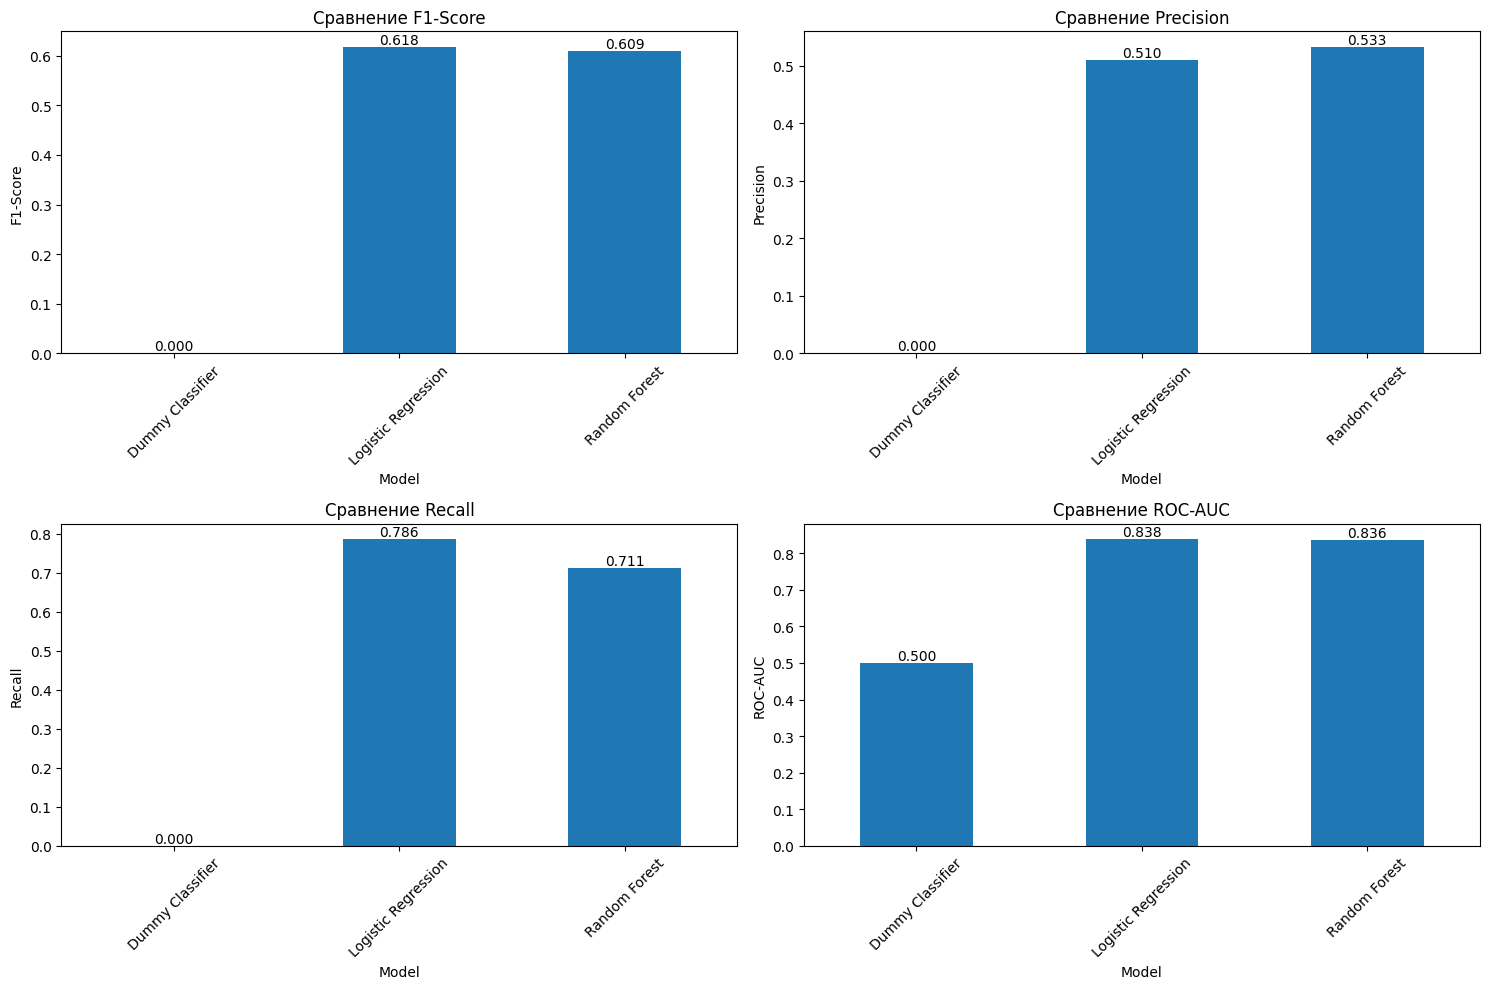

In [31]:
# Сравним качество всех подходов - дамми, логрега и деревьев

# Создаем таблицу сравнения
results_comparison = pd.DataFrame({
    'Model': ['Dummy Classifier', 'Logistic Regression', 'Random Forest'],
    'F1-Score': [f1_dummy, f1_logreg, f1_rf],
    'Precision': [precision_dummy, precision_logreg, precision_rf],
    'Recall': [recall_dummy, recall_logreg, recall_rf],
    'ROC-AUC': [roc_auc_dummy, roc_auc_logreg, roc_auc_rf]
})

print("=== СРАВНЕНИЕ МОДЕЛЕЙ ===")
print(results_comparison.round(4))

# Визуализация сравнения
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
metrics = ['F1-Score', 'Precision', 'Recall', 'ROC-AUC']

for i, metric in enumerate(metrics):
    ax = axes[i//2, i%2]
    results_comparison.plot(x='Model', y=metric, kind='bar', ax=ax, legend=False)
    ax.set_title(f'Сравнение {metric}')
    ax.set_ylabel(metric)
    ax.tick_params(axis='x', rotation=45)

    # Добавляем значения на столбцы
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.3f}',
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [32]:
# Classification report для логистической регрессии
print("=== CLASSIFICATION REPORT - LOGISTIC REGRESSION ===")
print(classification_report(y_test, y_pred_logreg,
                           target_names=['Не уходит (0)', 'Уходит (1)']))

# Детальный анализ
print("\n=== ДЕТАЛЬНЫЙ АНАЛИЗ ===")

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred_logreg)
tn, fp, fn, tp = cm.ravel()

print("Матрица ошибок:")
print(f"True Negative (TN):  {tn:4d} - Правильно предсказали 'не уходит'")
print(f"False Positive (FP): {fp:4d} - Ошибочно предсказали 'уходит' (лояльным клиентам)")
print(f"False Negative (FN): {fn:4d} - Пропустили уходящих клиентов")
print(f"True Positive (TP):  {tp:4d} - Правильно предсказали 'уходит'")

=== CLASSIFICATION REPORT - LOGISTIC REGRESSION ===
               precision    recall  f1-score   support

Не уходит (0)       0.90      0.73      0.81      1035
   Уходит (1)       0.51      0.79      0.62       374

     accuracy                           0.74      1409
    macro avg       0.71      0.76      0.71      1409
 weighted avg       0.80      0.74      0.76      1409


=== ДЕТАЛЬНЫЙ АНАЛИЗ ===
Матрица ошибок:
True Negative (TN):   752 - Правильно предсказали 'не уходит'
False Positive (FP):  283 - Ошибочно предсказали 'уходит' (лояльным клиентам)
False Negative (FN):   80 - Пропустили уходящих клиентов
True Positive (TP):   294 - Правильно предсказали 'уходит'


In [34]:
# Итак: лучшая модель - логистическая регрессия, она лучше находит уходящих клиентов, но у нее чуть больше ложных срабатываний, чем у random forest
# Но это будто не очень страшно, тк нам важнее перестраховаться и не пропустить ни одного уходящего клиента.
# Поэтому Recall тут важнее --> выигрывает логрег + у нее выше ROC-AUC

# Вот если бы нам, например, нужно было оптимизировать бюджет (минимизировать напрасные затраты на удержание), то можно было бы выбрать Random Forest, тк у него Precision выше
# Но, опять же, Precision не намного больше, чем у логрега, поэтому смысла будто не имеет